<a href="https://colab.research.google.com/github/choundurvishnu/Advance-Machine-Learning/blob/main/NMT_English_to_telugu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing the necessay packages**

In [ ]:
!pip install transformers sentencepiece datasets
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00


## **Importing all necessar packages**

## Packages

1.   dataset
2.   google colab
3.   numpy
4.   seaborn
5.   pandas
6.   torch
7.   transformers




In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch

from torch import optim
from torch.nn import functional as F

import tqdm
# from tqdm import tqdm_notebook

from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

#sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


#### Mounts Google Drive to the Colab notebook environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #/drive

Mounted at /content/drive


#### Path declaration

In [ ]:
directory = '/content/drive/My Drive/ATML_1/data/en-te/'

In [ ]:
files = {
    "train": (directory+"train/train.en", directory+"train/train.te"),
    "validation": (directory+"dev/dev.en", directory+"dev/dev.te"),
    "test": (directory+"test/test.en", directory+"test/test.te")
}

#### Loading data into variables and converting into dictornaries

In [ ]:
def load_data(files):
    data = {}
    for split, (en_file, te_file) in files.items():
        # Open the files and read the lines
        with open(en_file, encoding="utf-8") as en_f, open(te_file, encoding="utf-8") as te_f:
            en_lines = [line.strip() for line in en_f if line.strip()]
            te_lines = [line.strip() for line in te_f if line.strip()]

        # Check if the number of lines matches
        if len(en_lines) != len(te_lines):
            raise ValueError(f"The number of lines in the files for '{split}' split doesn't match.")

        # Combine the lines into translation pairs
        translations = [{"en": en, "te": te} for en, te in zip(en_lines, te_lines)]
        data[split] = Dataset.from_dict({"translation": translations})

    return DatasetDict(data)



dataset = load_data(files)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4946035
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2390
    })
})

In [ ]:
dataset['train'][0]

{'translation': {'en': 'Have you heard about Foie gras?',
  'te': 'ఇక ఫ్రూట్ ఫ్లైస్ గురించి మీరు విన్నారా?'}}

#### Selecting the 1Million of lines for training

In [ ]:
dataset1 = dataset
dataset1['train'] = dataset1['train'].select(range(1000000))

#### Importing the mT5 small model and tokenizer

In [ ]:
model_repo = 'google/mt5-small'
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
if torch.cuda.is_available():   #CUDA = torch.cuda.is_available()
  model = model.cuda()

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2390
    })
})

In [ ]:
train1 = dataset1['train']
test1 = dataset1['test']
valid1 = dataset1['validation']

In [ ]:
len(train1)

1000000

#### Converting dictonaries into dataframe

In [ ]:
import pandas as pd

def create_translation_df(dataset):
    source = [e['en'] for e in dataset['translation']]
    target = [e['te'] for e in dataset['translation']]
    return pd.DataFrame({
        'source': source,
        'target': target
    })

# Applying the function to each dataset
valid_df = create_translation_df(valid1)
test_df = create_translation_df(test1)
train_df = create_translation_df(train1)

#### Encoding the text data

In [ ]:
import torch

def encode_texts(df, column, tokenizer, max_length):
    # List comprehension for encoding the texts
    encoded = [tokenizer.encode(text, return_tensors="np", padding="max_length", truncation=True, max_length=max_length)[0]
               for text in df[column]]
    return torch.tensor(encoded)


In [ ]:
# Encoding source and target texts
input_pt = encode_texts(train_df, 'source', tokenizer, model.config.max_length)
output_pt = encode_texts(train_df, 'target', tokenizer, model.config.max_length)

# Moving tensors to GPU if available
if torch.cuda.is_available():
    input_pt = input_pt.cuda()
    output_pt = output_pt.cuda()

print(len(input_pt), len(output_pt))
print(input_pt.shape)
print(output_pt.shape)

<ipython-input-16-a3b67471ac83>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(encoded)


1000000 1000000
torch.Size([1000000, 20])
torch.Size([1000000, 20])


## Model Training Part

#### Hyperparameters






In [ ]:
n_epochs = 3
batch_size = 16
print_freq = 500
checkpoint_freq = 100
lr = 5e-4
n_batches = int(np.ceil(len(train_df) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def get_data_generator(inputs, outputs, batch_size=16):  # 16
  # inputs = inputs.shuffle()
  # outputs = outputs.shuffle()

  for i in range(0, len(inputs), batch_size):
    input_batch = inputs[i:i+batch_size]
    output_batch = outputs[i:i+batch_size]

    yield (input_batch, output_batch)

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(input_pt, output_pt, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)


In [ ]:
losses = []

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(input_pt, output_pt, batch_size)

  for batch_idx, (input_batch, label_batch) in tqdm.notebook.tqdm(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_df)
      print('Test loss of {:.3f}'.format(test_loss))
      # torch.save(model.state_dict(), model_path)


  0%|          | 0/62500 [00:00<?, ?it/s]

Test loss of 22.537
Test loss of 11.268
Test loss of 7.147
Test loss of 5.480
Epoch: 1 | Step: 500 | Avg. loss: 13.554 | lr: 0.00013333333333333334
Test loss of 4.204
Test loss of 3.310
Test loss of 3.009
Test loss of 2.806
Test loss of 2.649
Epoch: 1 | Step: 1000 | Avg. loss: 3.089 | lr: 0.0002666666666666667
Test loss of 2.515
Test loss of 2.396
Test loss of 2.310
Test loss of 2.243
Test loss of 2.205
Epoch: 1 | Step: 1500 | Avg. loss: 2.337 | lr: 0.0004
Test loss of 2.170
Test loss of 2.140
Test loss of 2.095
Test loss of 2.084
Test loss of 2.040
Epoch: 1 | Step: 2000 | Avg. loss: 2.154 | lr: 0.0004996632996632996
Test loss of 2.033
Test loss of 1.992
Test loss of 1.975
Test loss of 1.966
Test loss of 1.934
Epoch: 1 | Step: 2500 | Avg. loss: 2.055 | lr: 0.0004983164983164984
Test loss of 1.946
Test loss of 1.945
Test loss of 1.908
Test loss of 1.902
Test loss of 1.886
Epoch: 1 | Step: 3000 | Avg. loss: 1.996 | lr: 0.000496969696969697
Test loss of 1.880
Test loss of 1.865
Test loss 

  0%|          | 0/62500 [00:00<?, ?it/s]

Test loss of 0.862
Test loss of 0.885
Test loss of 0.898
Test loss of 0.909
Epoch: 2 | Step: 500 | Avg. loss: 1.377 | lr: 0.00033535353535353536
Test loss of 0.926
Test loss of 0.948
Test loss of 0.944
Test loss of 0.958
Test loss of 0.960
Epoch: 2 | Step: 1000 | Avg. loss: 1.387 | lr: 0.00033400673400673406
Test loss of 0.973
Test loss of 0.973
Test loss of 0.979
Test loss of 0.982
Test loss of 0.986
Epoch: 2 | Step: 1500 | Avg. loss: 1.377 | lr: 0.00033265993265993264
Test loss of 0.996
Test loss of 0.992
Test loss of 0.997
Test loss of 1.005
Test loss of 1.009
Epoch: 2 | Step: 2000 | Avg. loss: 1.378 | lr: 0.00033131313131313134
Test loss of 1.015
Test loss of 1.010
Test loss of 1.013
Test loss of 1.015
Test loss of 1.005
Epoch: 2 | Step: 2500 | Avg. loss: 1.369 | lr: 0.00032996632996633
Test loss of 1.022
Test loss of 1.022
Test loss of 1.017
Test loss of 1.024
Test loss of 1.010
Epoch: 2 | Step: 3000 | Avg. loss: 1.365 | lr: 0.0003286195286195287
Test loss of 1.022
Test loss of 1.

  0%|          | 0/62500 [00:00<?, ?it/s]

Test loss of 0.779
Test loss of 0.786
Test loss of 0.797
Test loss of 0.802
Epoch: 3 | Step: 500 | Avg. loss: 1.167 | lr: 0.00016700336700336703
Test loss of 0.809
Test loss of 0.821
Test loss of 0.819
Test loss of 0.824
Test loss of 0.826
Epoch: 3 | Step: 1000 | Avg. loss: 1.180 | lr: 0.00016565656565656567
Test loss of 0.832
Test loss of 0.834
Test loss of 0.836
Test loss of 0.837
Test loss of 0.838
Epoch: 3 | Step: 1500 | Avg. loss: 1.174 | lr: 0.00016430976430976434
Test loss of 0.845
Test loss of 0.845
Test loss of 0.847
Test loss of 0.849
Test loss of 0.852
Epoch: 3 | Step: 2000 | Avg. loss: 1.175 | lr: 0.00016296296296296298
Test loss of 0.854
Test loss of 0.855
Test loss of 0.854
Test loss of 0.861
Test loss of 0.863
Epoch: 3 | Step: 2500 | Avg. loss: 1.169 | lr: 0.00016161616161616162
Test loss of 0.865
Test loss of 0.863
Test loss of 0.867
Test loss of 0.872
Test loss of 0.864
Epoch: 3 | Step: 3000 | Avg. loss: 1.165 | lr: 0.00016026936026936026
Test loss of 0.864
Test loss o

#### Saving the model and tokenizer into drive

In [ ]:
import torch
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import pandas as pd
from sacrebleu import corpus_bleu

# Assume model and tokenizer have been initialized as shown earlier

def save_model_and_tokenizer(model, tokenizer, model_path, tokenizer_path):
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)

#torch.save(model.state_dict(), model_path)

#### Loading the modle and tokenizer

In [ ]:
# 2. Load the model and tokenizer
def load_model_and_tokenizer(model_path, tokenizer_path):
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    if torch.cuda.is_available():
        model = model.cuda()
    return model, tokenizer

#### Drive path to load/save the model and tokenizer

In [ ]:
#model_path = '/content/drive/My Drive/ATML_1/data/en-te/model_check/model_checkpoint.pth'
model_path = '/content/drive/My Drive/ATML_1/data/en-te/model_check/model/'
tokenizer_path = '/content/drive/My Drive/ATML_1/data/en-te/model_check/tokenizer/'


In [ ]:
save_model_and_tokenizer(model, tokenizer, model_path, tokenizer_path)

#model = load_model(model, model_path)

In [ ]:
model, tokenizer = load_model_and_tokenizer(model_path, tokenizer_path)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


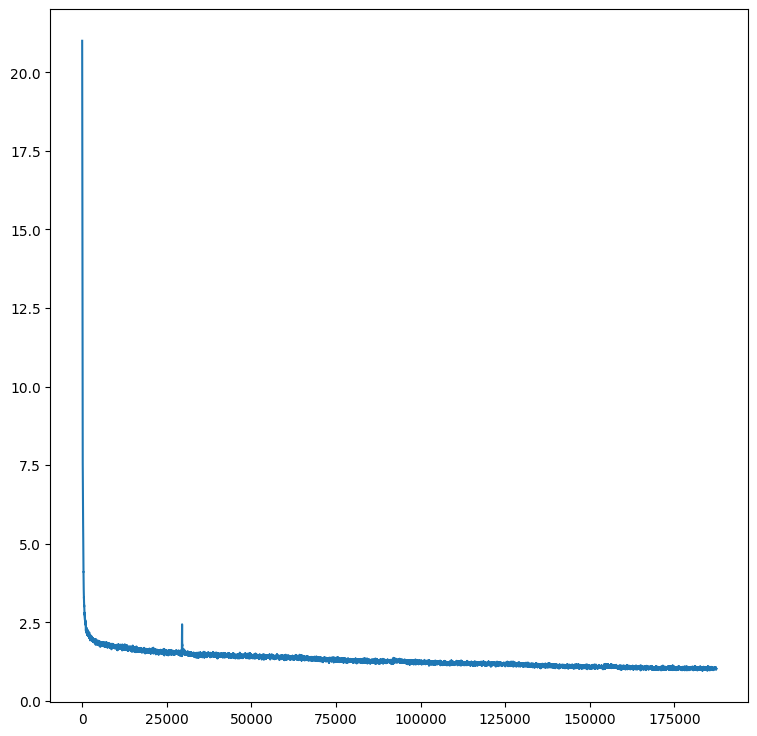

In [ ]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.figure(figsize=(9, 9))
plt.plot(smoothed_losses[100:])

## Evaluating the BLUE Score

In [ ]:
!pip install sacrebleu

In [ ]:
import sacrebleu

def evaluate_bleu(model, tokenizer, dataset, max_length, device='cpu'):
    model.eval()
    model.to(device)
    references = []
    hypotheses = []

    # Correcting iteration over DataFrame
    for index, example in dataset.iterrows():  # This ensures 'example' is a dictionary
        src_text = example['source']
        tgt_text = example['target']
        references.append([tgt_text])  # BLEU expects a list of possible references

        # Generate prediction using the model
        input_ids = tokenizer.encode(src_text, return_tensors="pt").to(device)
        output_ids = model.generate(input_ids, max_length=max_length)
        hypothesis = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        hypotheses.append(hypothesis)

    # Calculate BLEU score
    bleu_score = sacrebleu.corpus_bleu(hypotheses, references)
    return bleu_score

In [ ]:
# Evaluation
test_bleu_score = evaluate_bleu(model, tokenizer, test_df.sample(1), model.config.max_length)
print(f"BLEU score on test data: {test_bleu_score.score}")

BLEU score on test data: 5.11459870708889


#### Sample text sentence to translate into telugu

In [ ]:
id_to_test = 1
test_sentence_source = test_df.source.tolist()[id_to_test]
test_sentence_target = test_df.target.tolist()[id_to_test]
print("Input:")
print('Raw input text in Hindi:', test_sentence_source)
print('Expected text in English:', test_sentence_target)

model.cuda()
input_ids = tokenizer.encode(test_sentence_source, return_tensors="pt", padding="max_length", truncation=True, max_length=model.config.max_length)[0]
input_ids = input_ids.unsqueeze(0).cuda()
# print(input_ids)
print()

# print('Truncated input text:', tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0])))
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, max_length=model.config.max_length)
# print(output_tokens)
print("Output:")
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True, padding="max_length", truncation=True, max_length=model.config.max_length))


Input:
Raw input text in Hindi: We are proud to be the global host for World Environment Day, 2018.
Expected text in English: 2018 సంవత్సరపు ప్ర‌పంచ ప‌ర్యావ‌రణ దినానికి ప్రపంచ ఆతిథేయిగా ఉంటున్నందుకు మేం గ‌ర్విస్తున్నాము.

Output:
2018 ప్రపంచ పర్యావరణ దినోత్సవం కోసం ప్రపంచ వ్యాప్తంగా 


In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sample English sentence
english_sentence = "My name is Vishnu Chunduru"

input_text = english_sentence
# Encode the input text
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

# Generate translation outputs
translated_tokens = model.generate(input_ids, max_length=512)
translation = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print(f"Translated Sentence: {translation}")

Translated Sentence: నా పేరు విష్ణు చుండూరు.
